In [2]:
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt
import glob
import skimage

# BEE DETECT

In [3]:
# Load all images from TRAIN
train_imgs = np.array([np.array(imageio.imread(filename)) for filename in glob.glob('../TRAIN/*.jpg')])

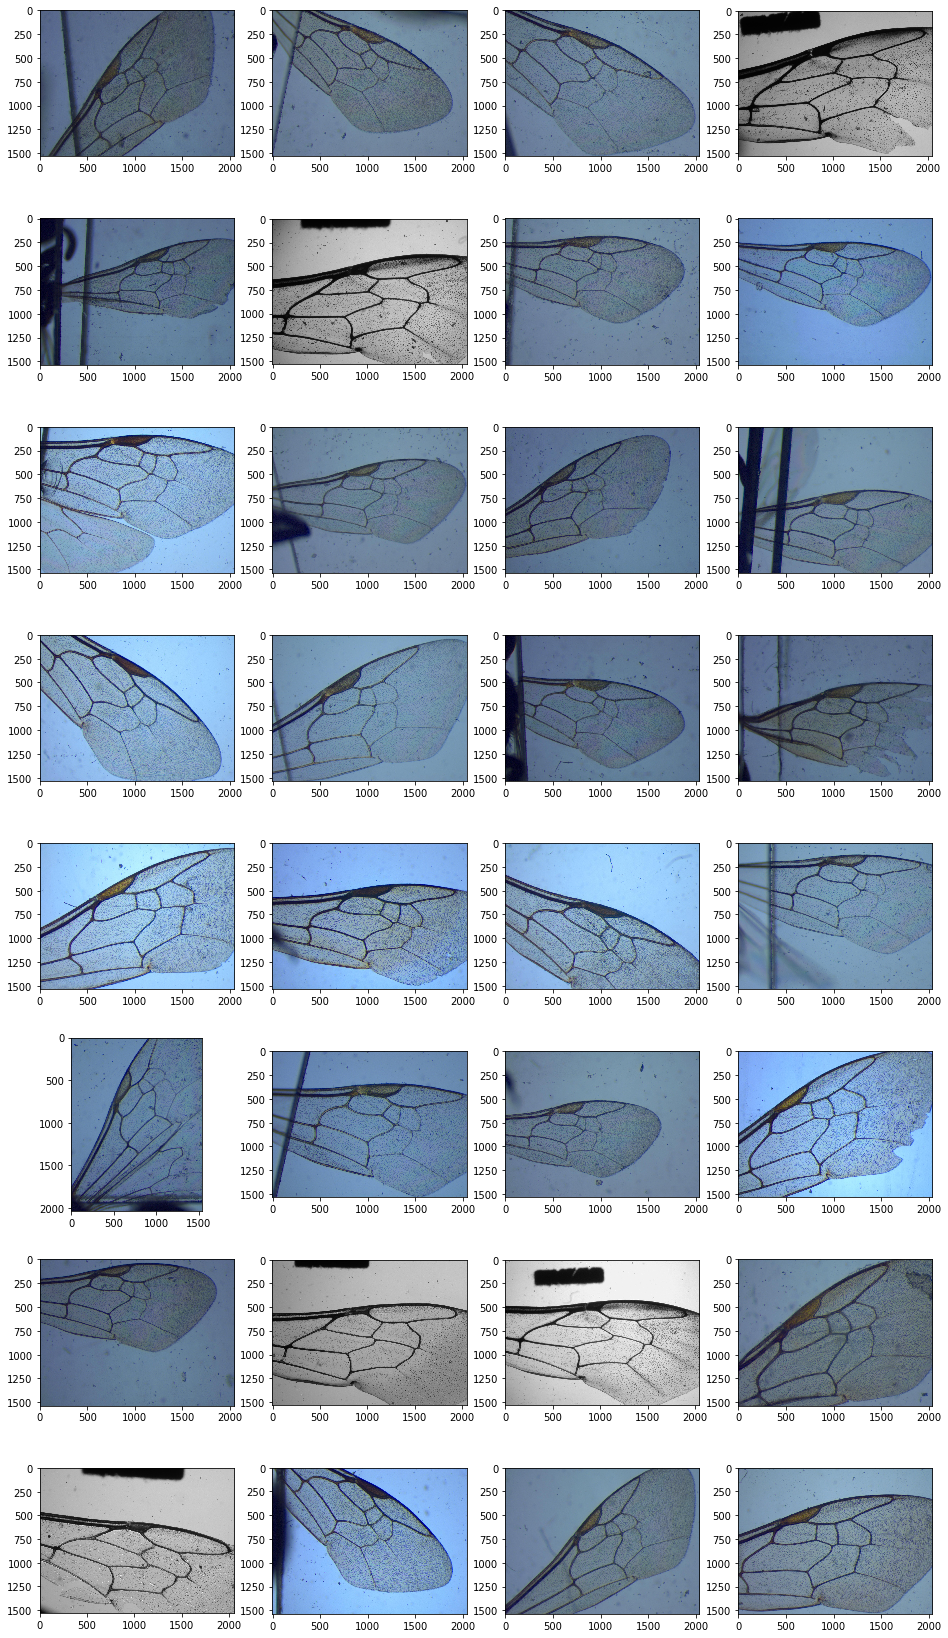

In [4]:
# Print all images from TRAIN
fig=plt.figure(figsize=(16, 30))
for i, img in enumerate(train_imgs):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(img)
plt.show()

In [212]:
# Load one image and CSV from TEST
test_img = imageio.imread('../TEST/01_inf.jpg')
test_points = np.genfromtxt('../TEST/01_inf.csv', delimiter=',')

In [213]:
# Draw points from CSV on the image
def draw_points(img, points):
    img_copy = img.copy()
    for point in points:
        cv2.circle(img_copy,(int(point[1]), int(point[0])), 20, (255,255,0), -1)
    return img_copy

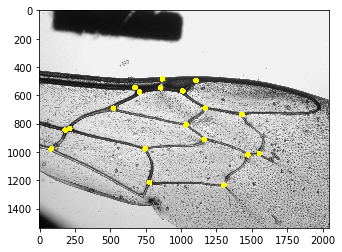

In [214]:
plt.imshow(draw_points(test_img, test_points))

## Threshold the image

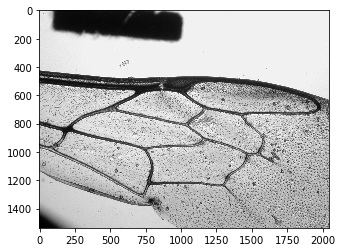

In [246]:
im = test_img
img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
img.shape, img.dtype
plt.imshow(img, cmap='gray')

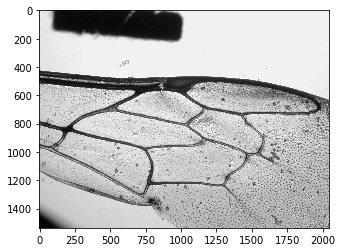

In [247]:
kernel = np.ones((3,3),np.uint8)
img = cv2.morphologyEx(img,cv2.MORPH_CLOSE,kernel, iterations = 1)
plt.imshow(img, cmap='gray')

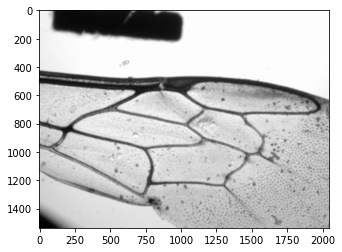

In [248]:
from skimage import exposure

for i in range(20):
    blur = cv2.GaussianBlur(img,(5,5),0)
    img = blur
plt.imshow(img, cmap='gray')



In [282]:
def otsu(arr):
    
    #Convert intensity values into int values
    arr = arr.astype(int)
    
    #List of intensity values
    vals = list(np.unique(arr))  
    vals_hist = list(np.copy(vals))   
    vals_hist.append(max(vals) + 1)

    #Compute the image histogram
    hist, bin_edges = np.histogram(arr, bins=vals_hist)

    #Normalize the histogram
    p_i = hist / hist.sum()

    #Test each threshold value partionning the histogram into 2 classes
    sigmas_b2 = []
    for cnt, threshold_val in enumerate(vals[0:len(vals) - 1]):
        w0 = p_i[0:cnt + 1].sum()
        w1 = p_i[cnt + 1:].sum()
        sigma_b2 = ((w0 * (vals * p_i).sum() - (vals[0:cnt + 1] * p_i[0:cnt + 1]).sum()) ** 2) / (w0 * w1)
        sigmas_b2.append(sigma_b2)
    threshold_val = vals[np.argmax(sigmas_b2)]
    return threshold_val

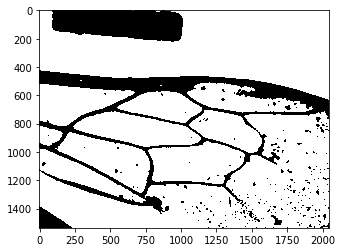

In [283]:
threshold_val = otsu(img)
bin_img = (img > threshold_val+18).astype(np.uint8)
plt.imshow(bin_img, cmap = 'gray')

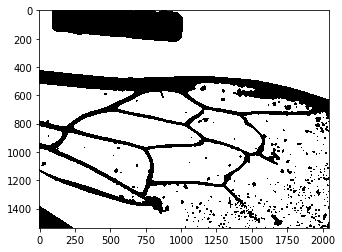

In [284]:
kernel = np.ones((5,5), np.uint8)
img_erosion = cv2.erode(bin_img, kernel, iterations=1) 
plt.imshow(img_erosion, cmap = 'gray')

## Connected Components

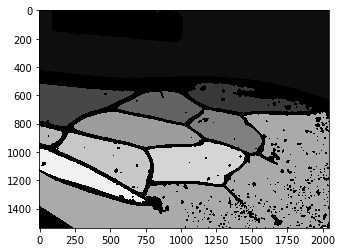

In [285]:
retval, markers = cv2.connectedComponents(img_erosion)
plt.imshow(markers, cmap='gray')

## Watershed

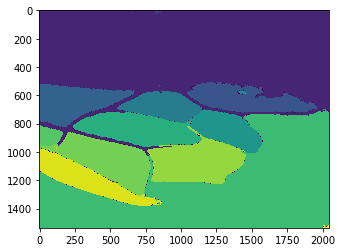

In [286]:
ws = cv2.watershed(im,markers)
plt.imshow(ws)

## Without Connected Components

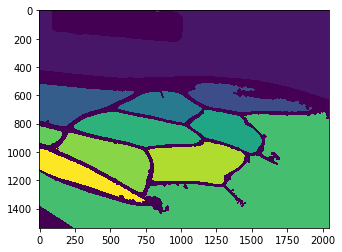

In [338]:
import skimage.morphology

all_labels = skimage.measure.label(1 - skimage.morphology.remove_small_objects((1 - img_erosion).astype(bool),min_size=5000))
plt.imshow(all_labels)

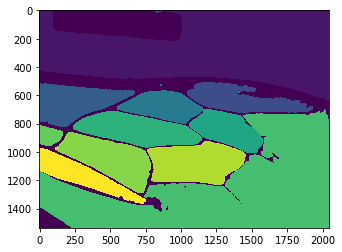

In [339]:
kernel = np.ones((5,5), np.uint8)
img_dilate = cv2.dilate(all_labels.astype(np.uint8), kernel, iterations=3) 
plt.imshow(img_dilate)

In [376]:
def intersect(img):
    height, width = img.shape
    step = 40
    points = []
    for i in range(0, height-step, 1):
        for j in range(0, width-step, 1):
            colors = set()
            if img[i][j] == 0:
                for k in range(i, i+step):
                    for l in range(j, j+step):
                        pixel = img[k][l]
                        if pixel not in colors:
                            colors.add(pixel)
                if len(colors) >= 4:
                    points.append((i+step//2, j+step//2))
    return points

In [ ]:
points = intersect(img_dilate)

In [ ]:
plt.imshow(draw_points(img, points))

# Detection on train images

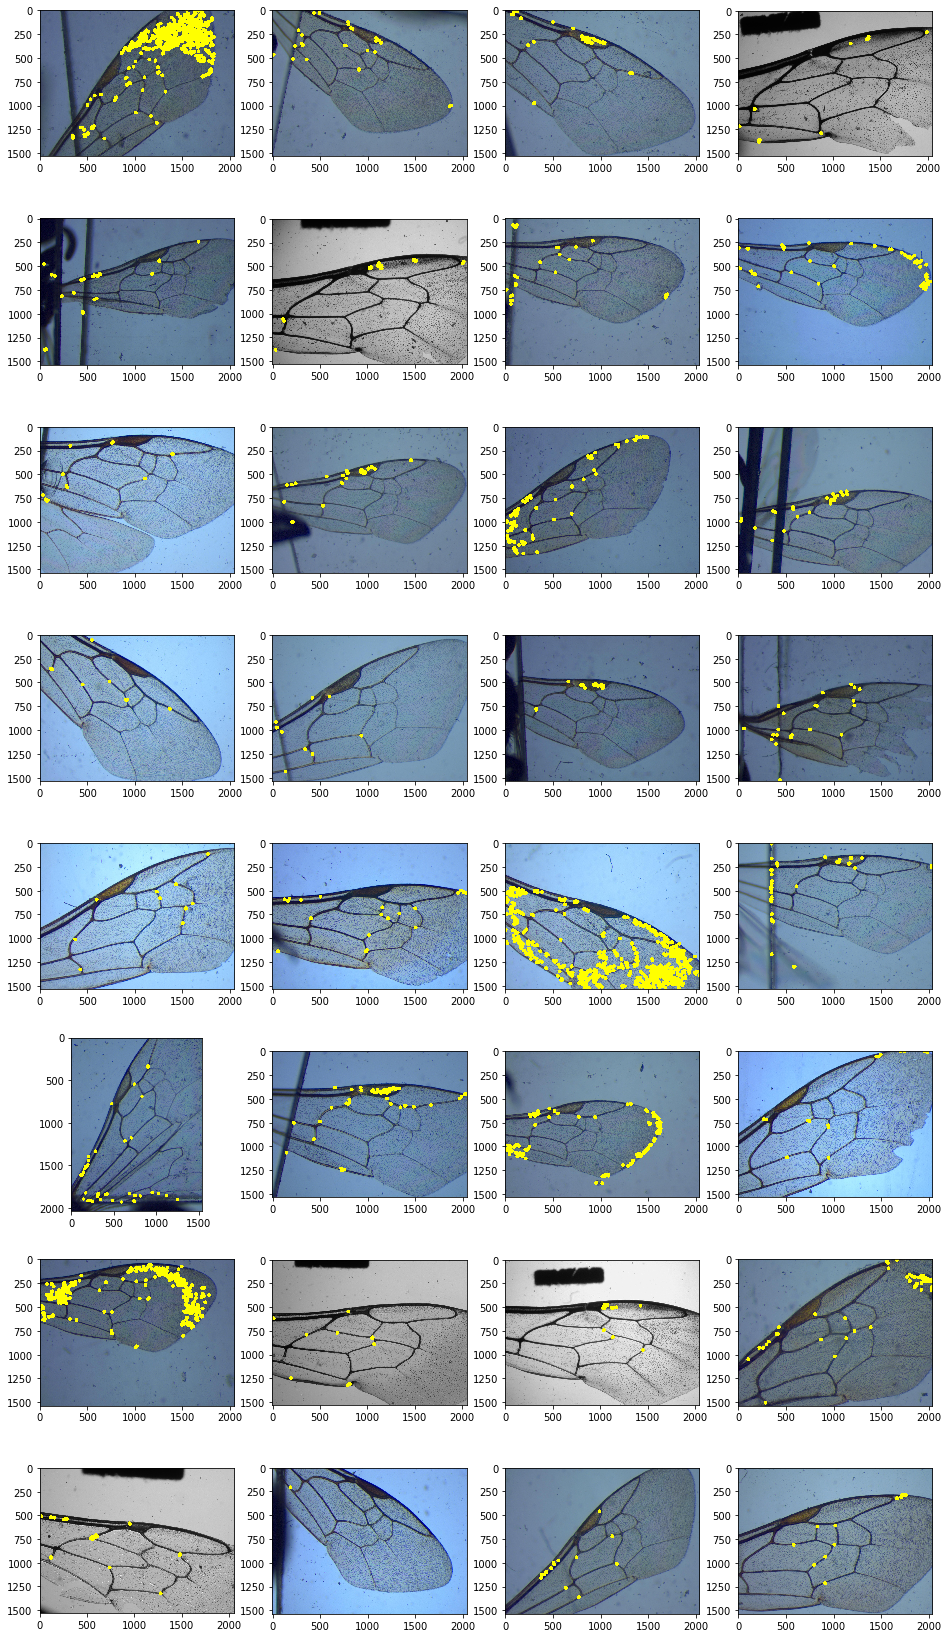

In [106]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process(img)
    points = intersect(ws)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(draw_points(img, points))
plt.show()


# Detection on test image

In [107]:
test_img = imageio.imread('../TEST/01_inf.jpg')
test_points = np.genfromtxt('../TEST/01_inf.csv', delimiter=',')
ws = process(test_img)
points = intersect(ws)

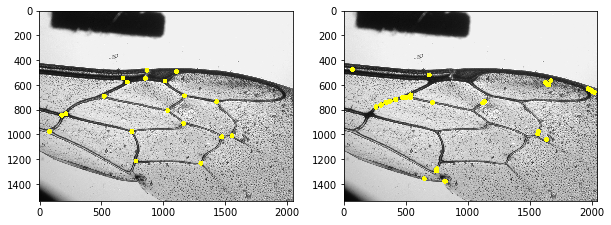

In [108]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(draw_points(test_img, test_points), cmap='nipy_spectral')

fig.add_subplot(1, 2, 2)
plt.imshow(draw_points(test_img, points))

plt.show()